<a href="https://colab.research.google.com/github/zhang8yiming/ComputerVision/blob/main/faster_rcnn%E6%95%B0%E6%8D%AE%E5%A4%84%E7%90%86.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## OpenCV Python 处理图片常用的库

In [ ]:

import cv2

# 测试的图片
img_path = '/content/dog.jpeg'

# 读取图片，numpy格式
image = cv2.imread(img_path)

# 通常在进行标准化时，先进行归一化，将数值范围限制在[0,1]之间，有图图像色彩值最大为255，所以这里除以255
image = image / 255.0

# 计算均值与标准差
# 返回值 m 是均值  s 是标准差
m, s = cv2.meanStdDev(image)

'''
m 和 s 的shape都是[3,1]
因为图片是彩色RGB图片，读取的是 3 通道数据 [height,width,channel]
在使用 api 计算的时候是分通道计算，所以得到的均值与标准差都是 3 个
'''
print (m)
print (s)

[[0.36335578]
 [0.46755861]
 [0.50495199]]
[[0.20944679]
 [0.22970699]
 [0.25739306]]


## 标准化（Normalize）

(3, 637, 960)
[0.36335578462165624, 0.46755860677588024, 0.5049519936178776]
[0.20944679026835686, 0.22970698879343374, 0.2573930641098645]
-----------
[3.5606364818014033e-08, 1.1698948359531157e-07, -4.49815173016901e-08]
[1.0000000356865033, 1.0000000110264167, 1.0000000284647592]


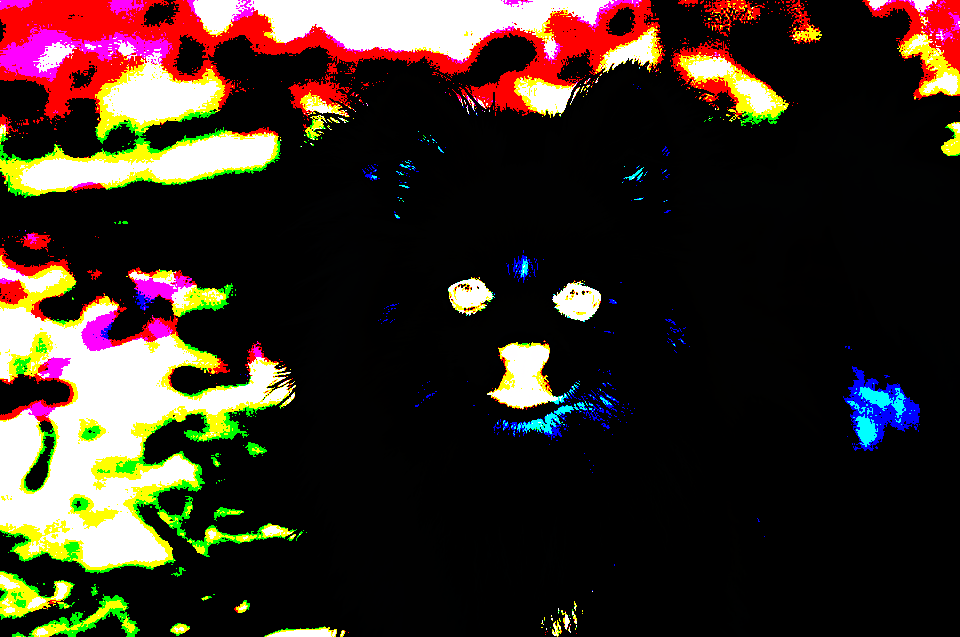

In [ ]:
import cv2
import torch
import numpy as np
from PIL import Image

# 测试图片路径
img_path = '/content/dog.jpeg'

# Tensor 执行的设备  这里设置 cpu
device = torch.device('cpu')

# 读取测试图片
img = cv2.imread(img_path)

# 这里做一下归一化，图片色彩值数值范围是 [0, 255]，除以 255 将数值规范到 [0, 1]
img = img / 255.0

# 使用 opencv 方法提取图片均值和标准差
m, s = cv2.meanStdDev(img)

# m 和 s 是List[List]类型  转换成 List
m = [x[0] for x in m]
s = [x[0] for x in s]

# opencv 在读取图片的时候默认是 channel last，也就是 [height, width, channel]，通道在最后一维
# pytorch 处理是 channel first，所以这里将维度换一下，np.transpose  是调换数组行列值的索引值
# [height, width, channel] -> [channel, height, width]
# [0, 1, 2] -> [2, 0, 1]
img = np.transpose(img,(2, 0, 1))
print(img.shape)

# 将准备好的图片数据转换成 Tensor
image = torch.as_tensor(img, dtype=torch.float32, device=device)

# 以上代码是准备 normalize 所需数据，模拟在 Faster RCNN 代码中传入 normalize 方法之前的数据状况

#=======================================================================================

def normalize(image, image_mean, image_std):

    """标准化处理"""
    ## 获取设备信息和数据类型，图像 image 现在是 Tensor 格式
    ## 和 Tensor 进行计算需要是同种类型数据以及在同一设备上，这里的设备可以是 cpu 也可以是某块 GPU
    ## 由于要和图片 image 进行计算，所以这里获取 image 的 type 和 device
    dtype, device = image.dtype, image.device

    ## image_mean 代表均值，将均值转成 Tensor
    mean = torch.as_tensor(image_mean, dtype=dtype, device=device)

    ## image_std 表示方差，将方差转成 Tensor
    std = torch.as_tensor(image_std, dtype=dtype, device=device)
    ## image 的 shape 是 [channel, height, width]，但是现在 mean 和 std 是[3]，在计算时需要进行下转换
    ## 转换方式是 [:, None, None]: shape [3] -> [3, 1, 1]
    return (image - mean[:, None, None]) / std[:, None, None]
#=======================================================================================
# 调用 normalize 方法，得到标准化之后的图片 Tensor
image = normalize(image, m, s)

# 现在的维度是 [1, channel, height, width] 所以去掉维度是1的变成 [channel, height, width]
image = image.squeeze(dim=0)

# 将 Tensor 转换成 numpy 以计算均值标准差和呈现图片
img1 = image.numpy()

# 将 channel first 转成 channel last
img1 = np.transpose(img1,(1, 2, 0)) 

# 计算新的均值和标准差
m_n, s_n = cv2.meanStdDev(img1)
m_n = [x[0] for x in m_n]
s_n = [x[0] for x in s_n]
print(m)
print(s)
print('-----------')
print(m_n)
print(s_n)
display(Image.fromarray(cv2.cvtColor(img1, cv2.COLOR_RGB2BGR).astype('uint8')))

## Resize

In [ ]:
import torch

def resize_boxes(boxes, original_size, new_size):
    # type: (Tensor, List[int], List[int]) -> Tensor
    """
    将boxes参数根据图像的缩放情况进行相应缩放

    Arguments:
        original_size: 图像缩放前的尺寸
        new_size: 图像缩放后的尺寸
    """
    # 下列列表生成式中，s 分别表示缩放后图像高和宽，s_orig 分别表示原图像高和宽
    # s 与 s_orig 转换成 Tensor 之后相除，得到了原图像与缩放后图像高和宽的缩放比例，类型为 Tensor
    ratios = [
        torch.tensor(s, dtype=torch.float32, device=boxes.device) /
        torch.tensor(s_orig, dtype=torch.float32, device=boxes.device)
        for s, s_orig in zip(new_size, original_size)
    ]
    ratios_height, ratios_width = ratios
    # boxes 的 shape=[num_of_box, 4]
    # unbind 在 dim=1 的维度进行拆分，xmin, ymin, xmax, ymax 分别是 [num_of_box]
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    
    # x y 坐标分别乘以对应的缩放比例得到缩放后的 x y 坐标
    xmin = xmin * ratios_width
    xmax = xmax * ratios_width
    ymin = ymin * ratios_height
    ymax = ymax * ratios_height
    return torch.stack((xmin, ymin, xmax, ymax), dim=1)

```
用法:
torch.unbind(input, dim=0) → seq
参数：
input(Tensor) -要解绑的张量

dim(int) -要删除的尺寸

删除张量维度。

返回沿给定维度的所有切片的元组，已经没有它。

例子：

>>> torch.unbind(torch.tensor([[1, 2, 3],
>>>                            [4, 5, 6],
>>>                            [7, 8, 9]]))
(tensor([1, 2, 3]), tensor([4, 5, 6]), tensor([7, 8, 9]))
```

In [ ]:
def torch_choice(l):
    # type: (List[int])
    """
    Implements `random.choice` via torch ops so it can be compiled with
    TorchScript. Remove if https://github.com/pytorch/pytorch/issues/25803
    is fixed.
    """
    index = int(torch.empty(1).uniform_(0., float(len(l))).item())
    return l[index]

In [ ]:
def resize(image, target, min_size=400, max_size=600):
    # type: (Tensor, Optional[Dict[str, Tensor]])

    """
    将图片缩放到指定的大小范围内，并对应缩放 bboxes 信息
    Args:
        image: Tensor，输入训练数据对应的 Tensor
        target: Dict[str, Tensor] 训练数据对应的标签信息，这一步用到
        
    Returns:
        image: 缩放后的图片
        target: 缩放bboxes后的图片相关信息
    """

    # 获取输入图像的高和宽
    h, w = image.shape[-2:]

    # 将高和宽值变成 Tensor
    im_shape = torch.tensor(image.shape[-2:])

    # 获取高宽中的最小值
    img_min_size = float(torch.min(im_shape))  

    # 获取高宽中的最大值
    img_max_size = float(torch.max(im_shape))  

    # 先用最小值尝试根据图像的最短边进行等比例缩放，观察下最大值是否在范围内
    # 根据指定最小边长和图片最小边长计算缩放比例
    scale_factor = min_size / img_min_size 

    # 如果使用该缩放比例计算的图片最大边长大于指定的最大边长
    if img_max_size * scale_factor > max_size:
        # 将缩放比例设为指定最大边长和图片最大边长之比
        scale_factor = max_size / img_max_size  

    # interpolate 利用插值的方法缩放图片，bilinear 是双线性插值
    # image[None] 操作是在最前面添加 batch 维度[C, H, W] -> [1, C, H, W]
    # bilinear 只支持 4D Tensor
    image = torch.nn.functional.interpolate(
        image[None], scale_factor=scale_factor, mode='bilinear', align_corners=False)[0]
        
    # 图片进行了一定程度的变换后，需要对target中的bbox进行相同的转换，因为bbox的坐标是原图resize之前的坐标
    bbox = target["boxes"]
    # 根据图像的缩放比例来缩放bbox
    bbox = resize_boxes(bbox, (h, w), image.shape[-2:])
    target["boxes"] = bbox

    return image, target, scale_factor

下面我们给出一个场景并制作出需要的“数据”，测试一下上面的代码，**运行下面的代码之前请务必运行上面定义方法的代码**。

In [ ]:
# 创建shape为[3, 500, 800]的“图片”
image = torch.zeros(3, 400, 700)
print('图片原始尺寸:', image.shape)

# 创建2个
box = torch.FloatTensor([[10, 5, 22, 18], [278, 355, 312, 401]]) 
print('标签信息：', box)
image_new, box_new, scale = resize(image, {'boxes' : box})
print('resize后图片尺寸：', image_new.shape)
print('resize后标签信息：', box_new)
print('缩放比例：', scale)

图片原始尺寸: torch.Size([3, 400, 700])
标签信息： tensor([[ 10.,   5.,  22.,  18.],
        [278., 355., 312., 401.]])
resize后图片尺寸： torch.Size([3, 342, 600])
resize后标签信息： {'boxes': tensor([[  8.5714,   4.2750,  18.8571,  15.3900],
        [238.2857, 303.5250, 267.4286, 342.8550]])}
缩放比例： 0.8571428571428571


## “打包”成batch

原始图像：


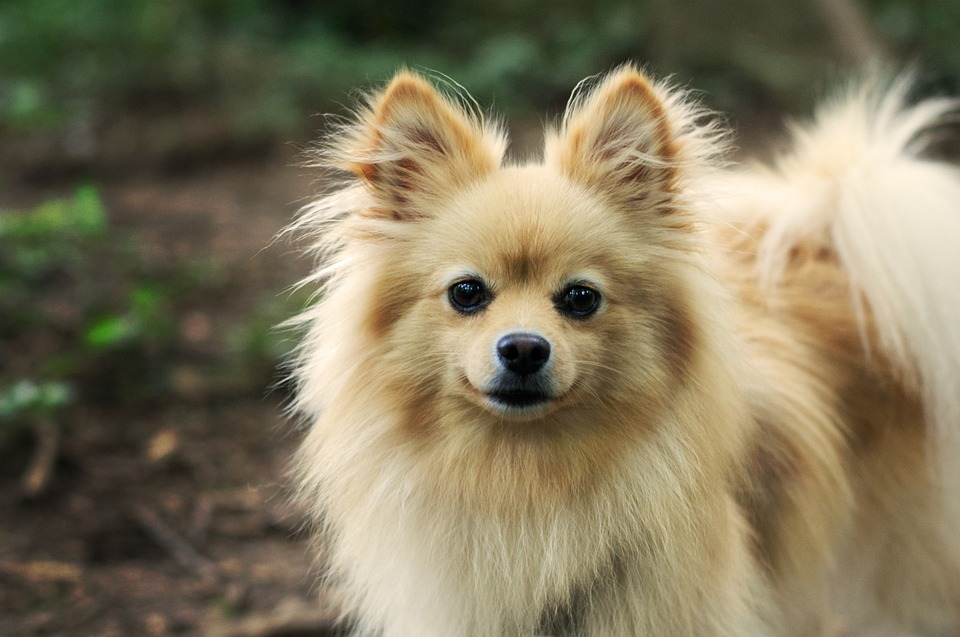

In [ ]:
import cv2
from PIL import Image

# 测试的图片
img_path = '/content/dog.jpeg'
resize_demo_img1 = cv2.imread(img_path)
print('原始图像：')
display(Image.fromarray(cv2.cvtColor(resize_demo_img1, cv2.COLOR_RGB2BGR).astype('uint8')))

resize之后的图像：


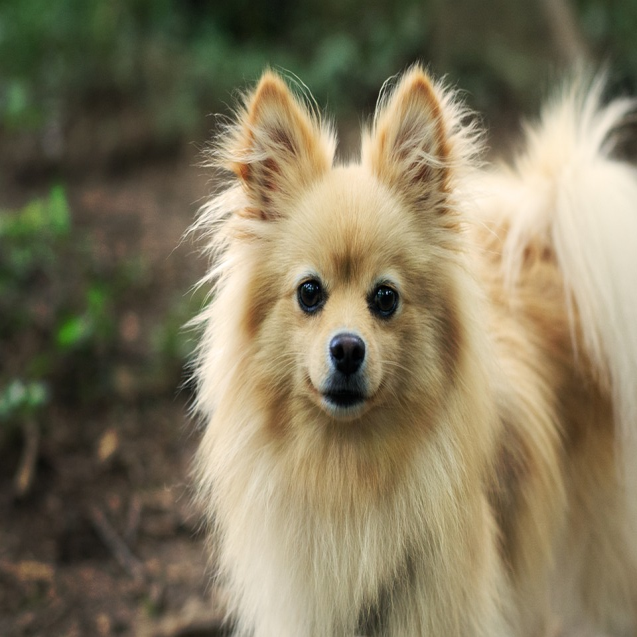

In [ ]:

resize_demo_img2 = cv2.resize(resize_demo_img1, (resize_demo_img1.shape[0], resize_demo_img1.shape[0]), interpolation = cv2.INTER_AREA)
print('resize之后的图像：')
display(Image.fromarray(cv2.cvtColor(resize_demo_img2, cv2.COLOR_RGB2BGR).astype('uint8')))

In [ ]:
import torch
import math
from PIL import Image
import cv2
import numpy as np

def max_by_axis(the_list):
    # type: (List[List[int]]) -> List[int]
    ## 将第一个赋值给max
    maxes = the_list[0]
    for sublist in the_list[1:]:
        for index, item in enumerate(sublist):
            maxes[index] = max(maxes[index], item)
    return maxes

def batch_images(images, size_divisible=32):
    # type: (List[Tensor], int)
    """
    将一批图像打包成一个 batch 返回（注意 batch 中每个 tensor 的 shape 是相同的）
    Args:
        images: 输入的一个 batch 的图片
        size_divisible: 将图像高和宽调整到该数的整数倍

    Returns:
        batched_imgs: 打包成一个 batch 后的 tensor 数据
    """

    # 分别计算一个 batch 中所有图片中的最大 channel, height, width
    max_size = max_by_axis([list(img.shape) for img in images])

    # 转换成 float 类型，方便参与计算
    stride = float(size_divisible)

    # max_size = list(max_size)
    # 将 height 向上调整到 stride 的整数倍
    max_size[1] = int(math.ceil(float(max_size[1]) / stride) * stride)

    # 将 width 向上调整到 stride 的整数倍
    max_size[2] = int(math.ceil(float(max_size[2]) / stride) * stride)

    # [batch, channel, height, width]
    batch_shape = [len(images)] + max_size

    # 创建shape为batch_shape且值全部为0的tensor
    batched_imgs = images[0].new_full(batch_shape, 0)
    for img, pad_img in zip(images, batched_imgs):
        # 将输入images中的每张图片复制到新的batched_imgs的每张图片中，对齐左上角，保证bboxes的坐标不变
        # 这样保证输入到网络中一个batch的每张图片的shape相同
        # copy_: Copies the elements from src into self tensor and returns self
        pad_img[: img.shape[0], : img.shape[1], : img.shape[2]].copy_(img)

    return batched_imgs

下面创建一点数据来测试一下上面的代码，**运行下面的代码之前请务必运行上面定义方法的代码**

组装成 batch 后的 shape： torch.Size([2, 3, 416, 416])


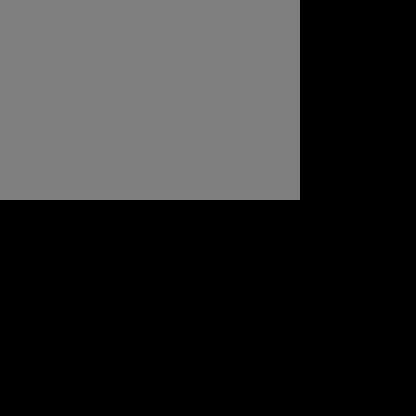

In [ ]:
images = []

# 创建一个长方形的“图片”
image1 = torch.ones(3, 200, 300)

# 创建一个较大的正方形“图片”
image2 = torch.ones(3, 400, 400)
images.append(image1)
images.append(image2)

batched_imgs = batch_images(images)
print('组装成 batch 后的 shape：', batched_imgs.shape)

# 根据代码中的逻辑，较小的image1进行了填充成正方形后再进行的resize，这时候我们看一下image1是什么样子
image1 = batched_imgs.numpy()[0]

# channel first转为channel last
image1 = np.transpose(image1, (1, 2, 0))

# 为了方便展示，乘以127.5
image1 = image1 * 127.5
display(Image.fromarray(cv2.cvtColor(image1, cv2.COLOR_RGB2BGR).astype('uint8')))

In [ ]:
import torch
from torch import nn, Tensor
import random
import math
from torch.jit.annotations import List, Tuple, Dict, Optional
import torchvision

In [ ]:
class ImageList(object):
    """
    Structure that holds a list of images (of possibly
    varying sizes) as a single tensor.
    This works by padding the images to the same size,
    and storing in a field the original sizes of each image
    """

    def __init__(self, tensors, image_sizes):
        # type: (Tensor, List[Tuple[int, int]])
        """
        Arguments:
            tensors (tensor) padding 后的图像数据
            image_sizes (list[tuple[int, int]])  padding 前的图像尺寸
        """
        self.tensors = tensors
        self.image_sizes = image_sizes

    def to(self, device):
        '''
        将 Tensor 移动到指定的 device 中
        Arguments:
            device 需要移动到的设备中
        '''
        # type: (Device) # noqa
        cast_tensor = self.tensors.to(device)
        return ImageList(cast_tensor, self.image_sizes)

In [ ]:
def resize_boxes(boxes, original_size, new_size):
    # type: (Tensor, List[int], List[int]) -> Tensor
    """
    将 boxes 参数根据图像的缩放情况进行相应缩放

    Arguments:
        original_size: 图像缩放前的尺寸
        new_size: 图像缩放后的尺寸
    """
    # 下列列表生成式中，s 分别表示缩放后图像高和宽，s_orig 分别表示原图像高和宽
    # s 与 s_orig 转换成 Tensor 之后相除，得到了原图像与缩放后图像高和宽的缩放比例，类型为 Tensor
    ratios = [
        torch.tensor(s, dtype=torch.float32, device=boxes.device) /
        torch.tensor(s_orig, dtype=torch.float32, device=boxes.device)
        for s, s_orig in zip(new_size, original_size)
    ]
    ratios_height, ratios_width = ratios

    # boxes 的 shape=[num_of_box, 4]
    # unbind 在 dim=1 的维度进行拆分，xmin,ymin,xmax,ymax分别是[num_of_box]
    xmin, ymin, xmax, ymax = boxes.unbind(1)

    # x y 坐标分别乘以对应的缩放比例得到缩放后的 x y 坐标
    xmin = xmin * ratios_width
    xmax = xmax * ratios_width
    ymin = ymin * ratios_height
    ymax = ymax * ratios_height
    return torch.stack((xmin, ymin, xmax, ymax), dim=1)

In [ ]:
class GeneralizedRCNNTransform(nn.Module):
    """
    Performs input / target transformation before feeding the data to a GeneralizedRCNN
    model.

    The transformations it perform are:
        - input normalization (mean subtraction and std division)
        - input / target resizing to match min_size / max_size

    It returns a ImageList for the inputs, and a List[Dict[Tensor]] for the targets
    """

    def __init__(self, min_size, max_size, image_mean, image_std):
        '''
        __init__方法在类初始化的时候调用的方法
        __init__方法的参数也是在初始化类时需要传入的方法
        通常用在__init__方法中传入一些必要的参数以及执行一些必要的前置代码和初始化代码

        Arguments
            min_size:指定图像的最小边长范围，type -> list or tuple
            max_size:指定图像的最大边长范围，type -> list or tuple
            image_mean:指定图像在标准化处理中的均值，通常是训练数据均值或其他数据集均值   type -> list[3]
            image_std:指定图像在标准化处理中的方差，通常是训练数据方差或其他数据集方差  type -> list[3]
        '''

        ## super()表示是父类的初始化方法，也就是父类的__init__方法
        super(GeneralizedRCNNTransform, self).__init__()

        ## 容错代码。isinstance判断传入参数是否是同一格式，返回True或者False
        if not isinstance(min_size, (list, tuple)):
            min_size = (min_size,)

        self.min_size = min_size      
        self.max_size = max_size      
        self.image_mean = image_mean  
        self.image_std = image_std    

    def normalize(self, image):
        """标准化处理"""
        ## 获取设备信息和数据类型，图像image现在是Tensor格式
        ## 和 Tensor 进行计算需要是同种类型数据以及在同一设备上，这里的设备可以是 cpu 也可以是某块 GPU
        ## 由于要和图片 image 进行计算，所以这里获取 image 的 type 和 device
        dtype, device = image.dtype, image.device

        ## image_mean 代表均值，将均值转成 Tensor
        mean = torch.as_tensor(self.image_mean, dtype=dtype, device=device)
        ## image_std 表示方差，将方差转成 Tensor
        std = torch.as_tensor(self.image_std, dtype=dtype, device=device)
        ## image 的 shape 是 [channel,height, width]，但是现在 mean 和 std 是[3]，在计算时需要进行下转换
        ## [:, None, None]: shape [3] -> [3, 1, 1]
        return (image - mean[:, None, None]) / std[:, None, None]

    def torch_choice(self, l):
        # type: (List[int])
        """
        Implements `random.choice` via torch ops so it can be compiled with
        TorchScript. Remove if https://github.com/pytorch/pytorch/issues/25803
        is fixed.
        """
        index = int(torch.empty(1).uniform_(0., float(len(l))).item())
        return l[index]

    def resize(self, image, target):
        # type: (Tensor, Optional[Dict[str, Tensor]])
        """
        将图片缩放到指定的大小范围内，并对应缩放 bboxes 信息
        Args:
            image:  输入的图片
            target: 输入图片的相关信息（包括 bboxes 信息）

        Returns:
            image:  缩放后的图片
            target: 缩放 bboxes 后的图片相关信息
        """
        # 获取输入图像的高和宽
        h, w = image.shape[-2:]

        # 将高和宽值变成 Tensor
        im_shape = torch.tensor(image.shape[-2:])

        # 获取高宽中的最小值
        min_size = float(torch.min(im_shape)) 

        # 获取高宽中的最大值
        max_size = float(torch.max(im_shape))  

        if self.training:
            # 指定输入图片的最小边长，注意是 self.min_size 不是 min_size
            # torch_choice 实现的功能和 random.choice 一样，对 Tensor 进行处理
            size = float(self.torch_choice(self.min_size))  
        else:
            # 指定输入图片的最小边长,注意是 self.min_size 不是 min_size
            size = float(self.min_size[-1])    
        # 根据指定最小边长和图片最小边长计算缩放比例
        scale_factor = size / min_size  

        # 如果使用该缩放比例计算的图片最大边长大于指定的最大边长
        if max_size * scale_factor > self.max_size:
            # 将缩放比例设为指定最大边长和图片最大边长之比
            scale_factor = self.max_size / max_size  

        # interpolate 利用插值的方法缩放图片
        # image[None] 操作是在最前面添加 batch 维度[C, H, W] -> [1, C, H, W]
        # bilinear 只支持 4D Tensor
        image = torch.nn.functional.interpolate(
            image[None], scale_factor=scale_factor, mode='bilinear', align_corners=False)[0]

        # 如果不是训练模式，target 是 None。直接返回结果
        if target is None:
            return image, target

        # 训练模式情况下，需要对 target 中的 bbox 进行转换，因为 bbox 的坐标是原图 resize 之前的坐标
        bbox = target["boxes"]

        # 根据图像的缩放比例来缩放bbox
        bbox = resize_boxes(bbox, (h, w), image.shape[-2:])
        target["boxes"] = bbox

        return image, target

    def max_by_axis(self, the_list):
        # type: (List[List[int]]) -> List[int]
        ## 将第一个赋值给 max
        maxes = the_list[0]
        for sublist in the_list[1:]:
            for index, item in enumerate(sublist):
                maxes[index] = max(maxes[index], item)
        return maxes

    def batch_images(self, images, size_divisible=32):
        # type: (List[Tensor], int)
        """
        将一批图像打包成一个batch返回（注意batch中每个tensor的shape是相同的）
        Args:
            images: 输入的一批图片
            size_divisible: 将图像高和宽调整到该数的整数倍

        Returns:
            batched_imgs: 打包成一个batch后的tensor数据
        """

        # 分别计算一个 batch 中所有图片中的最大 channel, height, width
        max_size = self.max_by_axis([list(img.shape) for img in images])

        # 转换成 float 类型，方便参与计算
        stride = float(size_divisible)

        # max_size = list(max_size)
        # 将 height 向上调整到 stride 的整数倍
        max_size[1] = int(math.ceil(float(max_size[1]) / stride) * stride)
        # 将 width 向上调整到 stride 的整数倍
        max_size[2] = int(math.ceil(float(max_size[2]) / stride) * stride)

        # [batch, channel, height, width]
        batch_shape = [len(images)] + max_size

        # 创建 shape 为 batch_shape 且值全部为 0 的 tensor
        batched_imgs = images[0].new_full(batch_shape, 0)
        for img, pad_img in zip(images, batched_imgs):
            # 将输入 images 中的每张图片复制到新的 batched_imgs 的每张图片中，对齐左上角，保证 bboxes 的坐标不变
            # 这样保证输入到网络中一个batch的每张图片的shape相同
            # copy_: Copies the elements from src into self tensor and returns self
            pad_img[: img.shape[0], : img.shape[1], : img.shape[2]].copy_(img)

        return batched_imgs

    def postprocess(self, result, image_shapes, original_image_sizes):
        # type: (List[Dict[str, Tensor]], List[Tuple[int, int]], List[Tuple[int, int]])
        """
        对网络的预测结果进行后处理（主要将bboxes还原到原图像尺度上）
        Args:
            result: list(dict), 网络的预测结果, len(result) == batch_size
            image_shapes: list(torch.Size), 图像预处理缩放后的尺寸, len(image_shapes) == batch_size
            original_image_sizes: list(torch.Size), 图像的原始尺寸, len(original_image_sizes) == batch_size

        Returns:

        """
        if self.training:
            # 训练过程不需要进行转换，只需要根据标注信息计算 loss 进行反向传播
            return result

        # 这部分内容没有实质的复杂逻辑。只是遍历图片数据获取原始图片尺寸与缩放后的图片尺寸，调用resize_boxes方法
        for i, (pred, im_s, o_im_s) in enumerate(zip(result, image_shapes, original_image_sizes)):
            boxes = pred["boxes"]
            boxes = resize_boxes(boxes, im_s, o_im_s)  # 将bboxes缩放回原图像尺度上
            result[i]["boxes"] = boxes
        return result

    def forward(self, images, targets=None): # type: -> (List[Tensor], Optional[List[Dict[str, Tensor]]])
        ## 将images转成List结构
        images = [img for img in images]
        ## 开始遍历数据并进行处理
        for i in range(len(images)):
            image = images[i]
            ## 容错代码，从逻辑上targets可以是None，train过程和inference过程需要对数据做同样的操作
            ## 在train的过程中targets为非None
            ## inference过程并不需要targets
            target_index = targets[i] if targets is not None else None
            ## 容错代码。dim()返回Tensor是几维的，这里验证数据合法性
            if image.dim() != 3:
                raise ValueError("images is expected to be a list of 3d tensors "
                                 "of shape [C, H, W], got {}".format(image.shape))
            ## 对图像进行标准化处理
            image = self.normalize(image) 

            ## 对图像和对应的 bboxes 缩放到指定范围
            ## 这里并不是把每张图片都强行缩放到一个尺寸，而是将图片按比例缩放到一个范围内，保证图片的原始比例
            image, target_index = self.resize(image, target_index) 

            ## 把经过标准化和 resize 处理后的数据放回原列表中  
            images[i] = image
            if targets is not None and target_index is not None:
                targets[i] = target_index

        ## 将 resize 之后的图片宽高保存下来，形成 list
        image_sizes = [img.shape[-2:] for img in images]

        ## 将 images 打包成一个 batch
        images = self.batch_images(images)

        ## 定义 List[Tuple[int, int]] 结构 List，初始值为[]
        image_sizes_list = torch.jit.annotate(List[Tuple[int, int]], [])

        ## 这里将前面收集的图片 resize 之后的尺寸遍历，放入新创建的 image_sizes_list 之中
        for image_size in image_sizes:
            ## 容错代码  验证是否有宽和高
            assert len(image_size) == 2
            image_sizes_list.append((image_size[0], image_size[1]))
        ## ImageList 中携带图像的 tensor 以及 resize 之后的图像尺寸
        ## 因为最后输出的是相对于 resize 之后的图像的框，我们需要转换成原图像的框
        ## 原图尺寸在 targets 里存储，resize 之后的尺寸在 ImageList 中
        image_list = ImageList(images, image_sizes_list)
        return image_list, targets